In [1]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 265 (delta 0), reused 1 (delta 0), pack-reused 264
Receiving objects: 100% (265/265), 12.88 MiB | 33.55 MiB/s, done.
Resolving deltas: 100% (123/123), done.


**How DETR works**


First, an image is sent through a pre-trained convolutional backbone (in the paper, the authors use ResNet-50/ResNet-101). Let’s assume we also add a batch dimension. This means that the input to the backbone is a tensor of shape (batch_size, 3, height, width), assuming the image has 3 color channels (RGB). The CNN backbone outputs a new lower-resolution feature map, typically of shape (batch_size, 2048, height/32, width/32). This is then projected to match the hidden dimension of the Transformer of DETR, which is 256 by default, using a nn.Conv2D layer. So now, we have a tensor of shape (batch_size, 256, height/32, width/32). Next, the feature map is flattened and transposed to obtain a tensor of shape (batch_size, seq_len, d_model) = (batch_size, width/32*height/32, 256). So a difference with NLP models is that the sequence length is actually longer than usual, but with a smaller d_model (which in NLP is typically 768 or higher).

Next, this is sent through the encoder, outputting encoder_hidden_states of the same shape (you can consider these as image features). Next, so-called object queries are sent through the decoder. This is a tensor of shape (batch_size, num_queries, d_model), with num_queries typically set to 100 and initialized with zeros. These input embeddings are learnt positional encodings that the authors refer to as object queries, and similarly to the encoder, they are added to the input of each attention layer. Each object query will look for a particular object in the image. The decoder updates these embeddings through multiple self-attention and encoder-decoder attention layers to output decoder_hidden_states of the same shape: (batch_size, num_queries, d_model). Next, two heads are added on top for object detection: a linear layer for classifying each object query into one of the objects or “no object”, and a MLP to predict bounding boxes for each query.

The model is trained using a bipartite matching loss: so what we actually do is compare the predicted classes + bounding boxes of each of the N = 100 object queries to the ground truth annotations, padded up to the same length N (so if an image only contains 4 objects, 96 annotations will just have a “no object” as class and “no bounding box” as bounding box). The Hungarian matching algorithm is used to find an optimal one-to-one mapping of each of the N queries to each of the N annotations. Next, standard cross-entropy (for the classes) and a linear combination of the L1 and generalized IoU loss (for the bounding boxes) are used to optimize the parameters of the model.

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
import sys
import numba
from tqdm.autonotebook import tqdm
from accelerate import Accelerator

# MAP
sys.path.append("../input/mean-average-precision/")
import mAP
import warnings

warnings.filterwarnings("ignore")
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# sklearn
from sklearn.model_selection import StratifiedKFold

# CV
import cv2


sys.path.append("./detr/")

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion


# Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models import resnet50

# Glob
from glob import glob

/tmp/ipykernel_24/1799928351.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

In [4]:
n_folds = 5
seed = 1001
num_classes = 2
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 16
LR = 1e-5
lr_backbone = 1e-4
EPOCHS = 40

In [5]:
# AS PER COMPETITION METRIC
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

# Seed Everything

Seeding everything for reproducible results

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [7]:
seed_everything(seed)

# Preparing the Data

* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [8]:
marking = pd.read_csv("../input/global-wheat-detection/train.csv")

bboxs = np.stack(marking["bbox"].apply(lambda x: np.fromstring(x[1:-1], sep=",")))
for i, column in enumerate(["x", "y", "w", "h"]):
    marking[column] = bboxs[:, i]
marking.drop(columns=["bbox"], inplace=True)

In [9]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[["image_id"]].copy()
df_folds.loc[:, "bbox_count"] = 1
df_folds = df_folds.groupby("image_id").count()
df_folds.loc[:, "source"] = (
    marking[["image_id", "source"]].groupby("image_id").min()["source"]
)
df_folds.loc[:, "stratify_group"] = np.char.add(
    df_folds["source"].values.astype(str),
    df_folds["bbox_count"].apply(lambda x: f"_{x // 15}").values.astype(str),
)
df_folds.loc[:, "fold"] = 0

for fold_number, (train_index, val_index) in enumerate(
    skf.split(X=df_folds.index, y=df_folds["stratify_group"])
):
    df_folds.loc[df_folds.iloc[val_index].index, "fold"] = fold_number

In [10]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.RandomBrightnessContrast(
                        brightness_limit=0.2, contrast_limit=0.2, p=0.3
                    ),
                    A.RGBShift(
                        r_shift_limit=20 / 255,
                        g_shift_limit=20 / 255,
                        b_shift_limit=10 / 255,
                        p=0.3,
                    ),
                ],
                p=0.2,
            ),
            A.OneOf(
                [
                    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
                    #                 A.Blur(p=0.6),
                    A.GaussNoise(var_limit=(0.01, 0.05), mean=0, p=0.05),
                    A.ToGray(p=0.05),
                ],
                p=0.2,
            ),
            A.OneOf(
                [
                    A.HorizontalFlip(p=1),
                    A.VerticalFlip(p=1),
                    A.Transpose(p=1),
                    A.RandomRotate90(p=1),
                ],
                p=1,
            ),
            #
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=5.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="coco", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

In [11]:
def get_valid_transforms():
    return A.Compose(
        [A.Resize(height=512, width=512, p=1.0), ToTensorV2(p=1.0)],
        p=1.0,
        bbox_params=A.BboxParams(
            format="coco", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

# Creating Dataset

* DETR accepts data in coco format which is (x,y,w,h). So now we need to prepare data in that format

In [12]:
def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        normalized_bboxes.append(normalized_bbox)
    return np.array(normalized_bboxes)


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return np.array(denormalized_bboxes)

In [13]:
DIR_TRAIN = "../input/global-wheat-detection/train"



class WheatDataset(Dataset):

    def __init__(self, image_ids, dataframe, transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms


    def __len__(self) -> int:


        return self.image_ids.shape[0]


    def __getitem__(self, index):

        image_id = self.image_ids[index]

        records = self.df[self.df["image_id"] == image_id]


        image = cv2.imread(f"{DIR_TRAIN}/{image_id}.jpg", cv2.IMREAD_COLOR)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        image /= 255.0


        # DETR takes in data in coco format

        boxes = records[["x", "y", "w", "h"]].values


        # Area of bb


        area = boxes[:, 2] * boxes[:, 3]


        area = torch.as_tensor(area, dtype=torch.float32)


        # AS pointed out by PRVI It works better if the main class is labelled as zero

        labels = np.zeros(len(boxes), dtype=np.int32)


        if self.transforms:

            sample = {"image": image, "bboxes": boxes, "labels": labels}


            sample = self.transforms(**sample)

            image = sample["image"]

            boxes = sample["bboxes"]

            labels = sample["labels"]


        # Normalizing BBOXES


        _, h, w = image.shape


        #         print(sample['bboxes'])

        #         hhghg

        boxes = normalize_bbox(sample["bboxes"], rows=h, cols=w)

        sample["bboxes"]

        target = {}


        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)

        target["labels"] = torch.as_tensor(labels, dtype=torch.long)

        target["image_id"] = torch.tensor([index])

        target["area"] = area


        return image, target, image_id

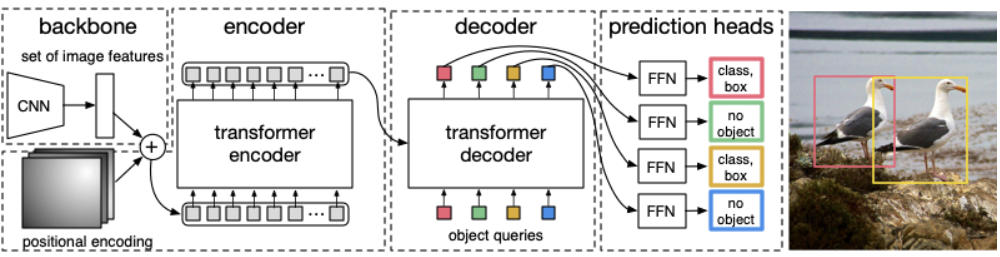

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [14]:
from typing import Optional


class TransformerEncoderLayer(nn.Module):

    def __init__(
        self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"
    ):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, src):
        q = k = src
        src2 = self.self_attn(q, k, value=src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src


class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src):
        output = src

        for layer in self.layers:
            output = layer(output)

        if self.norm is not None:
            output = self.norm(output)

        return output


import copy


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [15]:
class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt, memory):
        output = tgt

        for layer in self.layers:
            output = layer(output, memory)

        return output


class TransformerDecoderLayer(nn.Module):

    def __init__(
        self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"
    ):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, tgt, memory):
        q = k = tgt
        tgt2 = self.self_attn(q, k, value=tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=tgt, key=memory, value=memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

In [16]:
class Transformer(nn.Module):

    def __init__(
        self,
        d_model=256,
        nhead=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dim_feedforward=2048,
    ):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward)

        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward)

        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers)

        self.d_model = d_model
        self.nhead = nhead

    def forward(self, src, tgt):
        memory = self.encoder(src)
        hs = self.decoder(tgt, memory)
        return hs

In [17]:
class DETRModel(nn.Module):
    """
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    """

    def __init__(
        self,
        num_classes,
        num_queries,
        hidden_dim=256,
        nheads=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
    ):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = Transformer()
        #         nn.Transformer(
        #             hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = (
            torch.cat(
                [
                    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
                    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
                ],
                dim=-1,
            )
            .flatten(0, 1)
            .unsqueeze(1)
        )

        # propagate through the transformer
        #         k_v = pos + 0.1 * h.flatten(2).permute(2, 0, 1)
        #         print(k_v.size(),self.query_pos.unsqueeze(1).size())

        h = self.transformer(
            pos + 0.1 * h.flatten(2).permute(2, 0, 1),
            self.query_pos.unsqueeze(1).repeat(1, x.size(0), 1),
        ).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {
            "pred_logits": self.linear_class(h),
            "pred_boxes": self.linear_bbox(h).sigmoid(),
        }

In [18]:
def calculate_final_score(all_predictions, score_threshold, form):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]["gt_boxes"].copy()
        pred_boxes = all_predictions[i]["pred_boxes"].copy()
        scores = all_predictions[i]["scores"].copy()
        image_id = all_predictions[i]["image_id"]

        indexes = np.where(scores > score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]

        image_precision = mAP.calculate_image_precision(
            gt_boxes, pred_boxes, thresholds=iou_thresholds, form=form
        )
        final_scores.append(image_precision)

    return np.mean(final_scores)

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [19]:
"""
code taken from github repo detr , 'code present in engine.py'
"""

matcher = HungarianMatcher()

weight_dict = {"loss_ce": 0.5, "loss_bbox": 1, "loss_giou": 1}

losses = ["labels", "boxes", "cardinality"]

# Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [20]:
def train_fn(
    data_loader,
    model,
    criterion,
    optimizer,
    device,
    accelerator,
    st,
    epoch,
    max_norm=0.1,
):
    model.train()
    criterion.train()


    total_loss = AverageMeter()

    bbox_loss = AverageMeter()

    giou_loss = AverageMeter()

    labels_loss = AverageMeter()


    tk0 = tqdm(data_loader, total=len(data_loader))


    for step, (images, targets, image_ids) in enumerate(tk0):


        images = list(image.to(device) for image in images)


        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        output = model(torch.stack(images))


        loss_dict = criterion(output, targets)

        weight_dict = criterion.weight_dict


        losses = sum(
            loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict
        )


        optimizer.zero_grad()


        losses.backward()

        if max_norm > 0:

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()

        accelerator.log({"total_loss_step": losses.item()}, step=st)

        accelerator.log({"loss_bbox": loss_dict["loss_bbox"].item()}, step=st)

        accelerator.log({"loss_giou": loss_dict["loss_giou"].item()}, step=st)

        accelerator.log({"loss_ce": loss_dict["loss_ce"].item()}, step=st)


        total_loss.update(losses.item(), BATCH_SIZE)

        bbox_loss.update(loss_dict["loss_bbox"].item())

        giou_loss.update(loss_dict["loss_giou"].item())

        labels_loss.update(loss_dict["loss_ce"].item())

        st += 1

        tk0.set_postfix(
            bbox_loss=bbox_loss.avg,
            giou_loss=giou_loss.avg,
            labels_loss=labels_loss.avg,
            total_loss=total_loss.avg,
        )


    return total_loss, st

# Eval Function

In [21]:
def eval_fn(data_loader, model, criterion, device):
    model.eval()
    criterion.eval()
    all_predictions = []

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(torch.stack(images))

            for i in range(len(images)):
                boxes = output["pred_boxes"][i].detach().cpu().numpy()
                scores = (
                    output["pred_logits"][i].softmax(1).detach().cpu().numpy()[:, 0]
                )
                gt_boxes = targets[i]["boxes"].cpu().numpy()

                _, h, w = images[i].shape
                boxes = np.array(
                    [[x, y, w, h] for x, y, w, h in denormalize_bbox(boxes, h, w)]
                ).astype(np.int32)
                gt_boxes = np.array(
                    [[x, y, w, h] for x, y, w, h in denormalize_bbox(gt_boxes, h, w)]
                ).astype(np.int32)

                all_predictions.append(
                    {
                        "pred_boxes": boxes,
                        "scores": scores,
                        "gt_boxes": gt_boxes,
                        "image_id": image_ids[i],
                    }
                )

    return all_predictions

# Engine

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

Training DETR from Scratch is tricky you would need large data and require more GPU hour*
600 epoch on CoCo dataset

**we are using pretrained model weights for faster convergence**

In [23]:
def run(fold):

    df_train = df_folds[df_folds["fold"] != fold]
    df_valid = df_folds[df_folds["fold"] == fold]

    train_dataset = WheatDataset(
        image_ids=df_train.index.values,
        dataframe=marking,
        transforms=get_train_transforms(),
    )

    valid_dataset = WheatDataset(
        image_ids=df_valid.index.values,
        dataframe=marking,
        transforms=get_valid_transforms(),
    )

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
    )

    device = torch.device("cuda")
    model = DETRModel(num_classes=num_classes, num_queries=num_queries)
    state_dict = torch.hub.load_state_dict_from_url(
        url="https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth",
        map_location="cpu",
        check_hash=True,
    )
    del state_dict["linear_class.weight"]
    del state_dict["linear_class.bias"]
    model.load_state_dict(state_dict, strict=False)
    #     model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    #     param_dicts = [
    #         {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
    #         {
    #             "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
    #             "lr": lr_backbone,
    #         },
    #     ]
    model = model.to(device)
    criterion = SetCriterion(
        num_classes - 1, matcher, weight_dict, eos_coef=null_class_coef, losses=losses
    )
    criterion = criterion.to(device)

    accelerator = Accelerator(log_with="tensorboard", project_dir=".")
    #     accelerator = Accelerator(mixed_precision='bf16')

    accelerator.init_trackers(f"detr_project")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)  # weight_decay=1e-4

    best_map = 0
    st = 0
    for epoch in range(EPOCHS):
        train_loss, st = train_fn(
            train_data_loader,
            model,
            criterion,
            optimizer,
            device,
            accelerator,
            st,
            epoch=epoch,
        )
        predictions = eval_fn(valid_data_loader, model, criterion, device)

        valid_map_score = calculate_final_score(predictions, 0.5, form="coco")

        print(
            "|EPOCH {}| TRAIN_LOSS {}| VALID_MAP_SCORE {}|".format(
                epoch + 1, train_loss.avg, valid_map_score
            )
        )

        if valid_map_score > best_map:
            best_map = valid_map_score
            print(
                "Best model for Fold {} found in Epoch {}........Saving Model".format(
                    fold, epoch + 1
                )
            )
            torch.save(model.state_dict(), f"detr_best_{fold}.pth")
    accelerator.end_training()

**Need extremely long training to converge, vs epochs for Faster FRCNN**

In [24]:
run(fold=0)

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth
100%|██████████| 79.3M/79.3M [00:00<00:00, 116MB/s]
2024-06-03 20:15:40.603820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 20:15:40.603954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 20:15:40.738412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 1.5366395747167825| VALID_MAP_SCORE 0.008905618814675668|
Best model for Fold 0 found in Epoch 1........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 1.3996503910369422| VALID_MAP_SCORE 0.012107413987276903|
Best model for Fold 0 found in Epoch 2........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 1.361181011566749| VALID_MAP_SCORE 0.013917044559520756|
Best model for Fold 0 found in Epoch 3........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 1.3331912036478166| VALID_MAP_SCORE 0.01760979860896234|
Best model for Fold 0 found in Epoch 4........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 1.3065536396037898| VALID_MAP_SCORE 0.02136577853279568|
Best model for Fold 0 found in Epoch 5........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 6| TRAIN_LOSS 1.2768050234698685| VALID_MAP_SCORE 0.026513127506756058|
Best model for Fold 0 found in Epoch 6........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 7| TRAIN_LOSS 1.2458108910442105| VALID_MAP_SCORE 0.03374859497483813|
Best model for Fold 0 found in Epoch 7........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 8| TRAIN_LOSS 1.2121033217074604| VALID_MAP_SCORE 0.04518467886555198|
Best model for Fold 0 found in Epoch 8........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 9| TRAIN_LOSS 1.1825904796814777| VALID_MAP_SCORE 0.050993471716830364|
Best model for Fold 0 found in Epoch 9........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 10| TRAIN_LOSS 1.1514232638319568| VALID_MAP_SCORE 0.06461691426055034|
Best model for Fold 0 found in Epoch 10........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 11| TRAIN_LOSS 1.1229731592200918| VALID_MAP_SCORE 0.07810122615714105|
Best model for Fold 0 found in Epoch 11........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 12| TRAIN_LOSS 1.089932714693645| VALID_MAP_SCORE 0.0951385626879081|
Best model for Fold 0 found in Epoch 12........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 13| TRAIN_LOSS 1.05992997609652| VALID_MAP_SCORE 0.10984443073390994|
Best model for Fold 0 found in Epoch 13........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 14| TRAIN_LOSS 1.0342179653207226| VALID_MAP_SCORE 0.12490759994502203|
Best model for Fold 0 found in Epoch 14........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 15| TRAIN_LOSS 1.009121607393908| VALID_MAP_SCORE 0.14014039142996737|
Best model for Fold 0 found in Epoch 15........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 16| TRAIN_LOSS 0.9844333155620733| VALID_MAP_SCORE 0.15905451839175305|
Best model for Fold 0 found in Epoch 16........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 17| TRAIN_LOSS 0.9618379791107403| VALID_MAP_SCORE 0.17682985993702657|
Best model for Fold 0 found in Epoch 17........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 18| TRAIN_LOSS 0.940324609801614| VALID_MAP_SCORE 0.19041494937378797|
Best model for Fold 0 found in Epoch 18........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 19| TRAIN_LOSS 0.928084699007181| VALID_MAP_SCORE 0.205662410654093|
Best model for Fold 0 found in Epoch 19........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 20| TRAIN_LOSS 0.9134850621928831| VALID_MAP_SCORE 0.21303604120064393|
Best model for Fold 0 found in Epoch 20........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 21| TRAIN_LOSS 0.8996350112751391| VALID_MAP_SCORE 0.23006569893232787|
Best model for Fold 0 found in Epoch 21........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 22| TRAIN_LOSS 0.8859896977272259| VALID_MAP_SCORE 0.2397774311669759|
Best model for Fold 0 found in Epoch 22........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 23| TRAIN_LOSS 0.8729097783212831| VALID_MAP_SCORE 0.25603073533839227|
Best model for Fold 0 found in Epoch 23........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 24| TRAIN_LOSS 0.8622373085050188| VALID_MAP_SCORE 0.25741414036651894|
Best model for Fold 0 found in Epoch 24........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 25| TRAIN_LOSS 0.852626225652074| VALID_MAP_SCORE 0.2795751532023893|
Best model for Fold 0 found in Epoch 25........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 26| TRAIN_LOSS 0.8398502447901393| VALID_MAP_SCORE 0.28260947817566184|
Best model for Fold 0 found in Epoch 26........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 27| TRAIN_LOSS 0.8293686537347602| VALID_MAP_SCORE 0.2866990267288678|
Best model for Fold 0 found in Epoch 27........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 28| TRAIN_LOSS 0.8228405061558154| VALID_MAP_SCORE 0.3026838083986344|
Best model for Fold 0 found in Epoch 28........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 29| TRAIN_LOSS 0.8160389298518028| VALID_MAP_SCORE 0.3106654868684244|
Best model for Fold 0 found in Epoch 29........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 30| TRAIN_LOSS 0.8082838894347467| VALID_MAP_SCORE 0.31177298618589844|
Best model for Fold 0 found in Epoch 30........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 31| TRAIN_LOSS 0.799945978370644| VALID_MAP_SCORE 0.32039464537085566|
Best model for Fold 0 found in Epoch 31........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 32| TRAIN_LOSS 0.7923660253631998| VALID_MAP_SCORE 0.3288466067382384|
Best model for Fold 0 found in Epoch 32........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 33| TRAIN_LOSS 0.7863879909176799| VALID_MAP_SCORE 0.33809297031949304|
Best model for Fold 0 found in Epoch 33........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 34| TRAIN_LOSS 0.780141775777354| VALID_MAP_SCORE 0.3380945766942442|
Best model for Fold 0 found in Epoch 34........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 35| TRAIN_LOSS 0.7763896542187978| VALID_MAP_SCORE 0.34184022384220875|
Best model for Fold 0 found in Epoch 35........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 36| TRAIN_LOSS 0.7722884307246236| VALID_MAP_SCORE 0.3450625831655284|
Best model for Fold 0 found in Epoch 36........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 37| TRAIN_LOSS 0.7676431857622587| VALID_MAP_SCORE 0.3521934982827492|
Best model for Fold 0 found in Epoch 37........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 38| TRAIN_LOSS 0.7655164920366727| VALID_MAP_SCORE 0.35568154102132615|
Best model for Fold 0 found in Epoch 38........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 39| TRAIN_LOSS 0.7605718755157742| VALID_MAP_SCORE 0.3551035578873213|


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 40| TRAIN_LOSS 0.7533569173700005| VALID_MAP_SCORE 0.36688289197499985|
Best model for Fold 0 found in Epoch 40........Saving Model


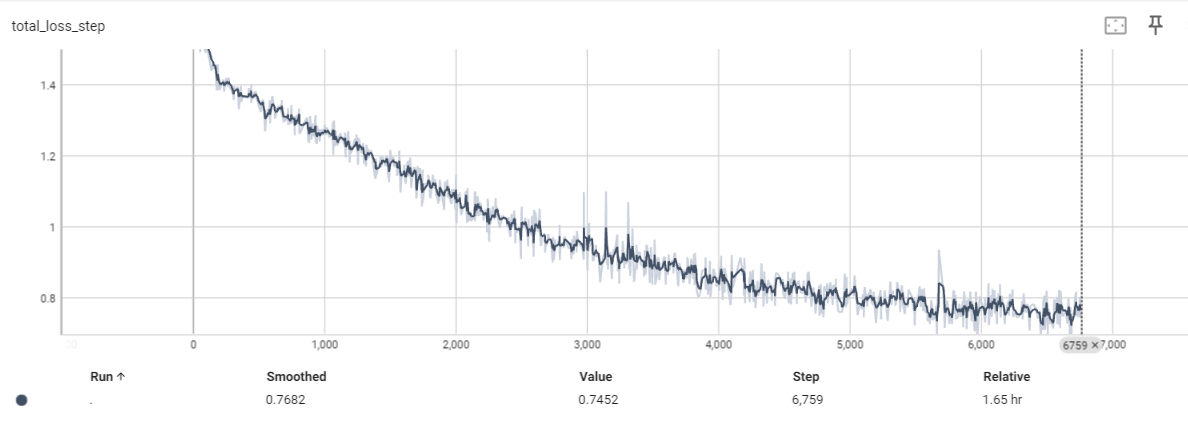

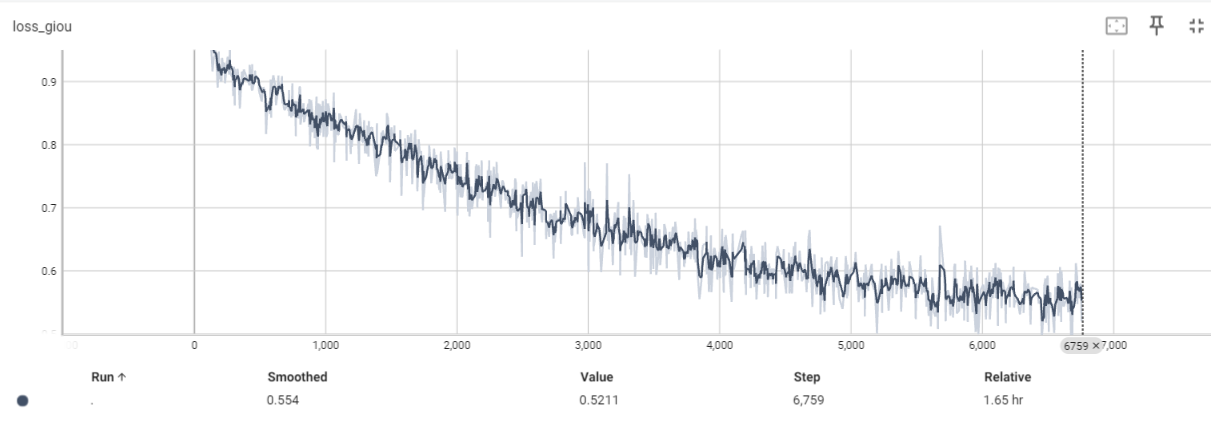

In [25]:
model = DETRModel(num_classes=num_classes, num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))

<All keys matched successfully>

In [26]:
df_valid = df_folds[df_folds["fold"] == 0]
valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms(),
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

images, targets, image_ids = next(iter(valid_data_loader))
# _,h,w = images[0].shape # for de normalizing images
device = torch.device("cuda")
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [27]:
def view_sample(images, targets, image_ids, model, device):

    _, h, w = images.shape  # for de normalizing images

    boxes = targets["boxes"].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in denormalize_bbox(boxes, h, w)]
    sample = images.permute(1, 2, 0).cpu().numpy()

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images.unsqueeze(0))

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(
            sample, (box[0], box[1]), (box[2] + box[0], box[3] + box[1]), (220, 0, 0), 1
        )

    oboxes = outputs[0]["pred_boxes"][0].detach().cpu().numpy()
    oboxes = denormalize_bbox(oboxes, rows=h, cols=w)
    prob = outputs[0]["pred_logits"][0].softmax(1).detach().cpu().numpy()[:, 0]

    for box, p in zip(oboxes, prob):

        if p > 0.55:
            color = (0, 1, 0)  # if p>0.5 else (0,0,0)
            cv2.rectangle(
                sample,
                (int(box[0]), int(box[1])),
                (int(box[2] + box[0]), int(box[3] + box[1])),
                color,
                1,
            )

    ax.set_axis_off()
    ax.imshow(sample)

**Red-Original**


**Green-predicted**

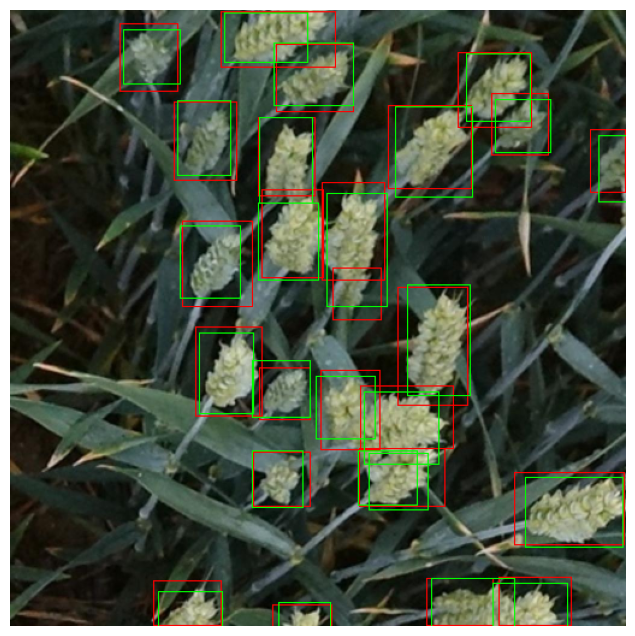

In [28]:
view_sample(images[0], targets[0], image_ids[0], model, device)

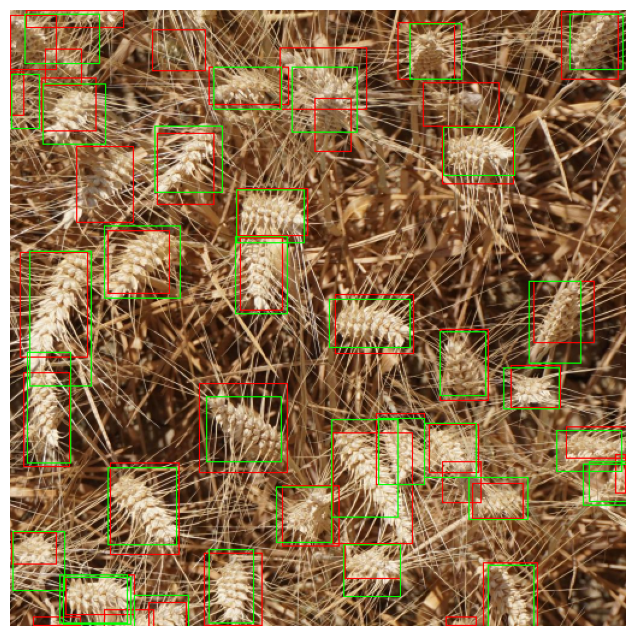

In [29]:
view_sample(images[1], targets[1], image_ids[1], model, device)

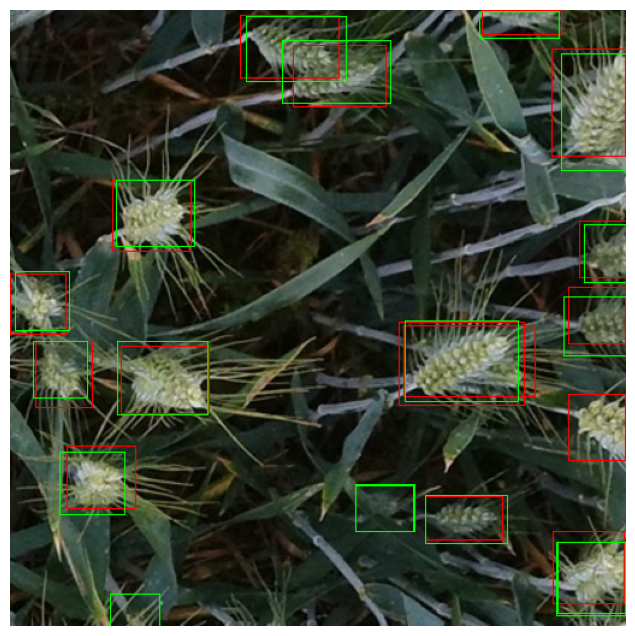

In [30]:
view_sample(images[2], targets[2], image_ids[2], model, device)

Reference: https://www.kaggle.com/code/tanulsingh077/end-to-end-object-detection-with-transformers-detr

**To-Do: extent this to Open Vocab object detection**